In [1]:
import os
import numpy as np
from scipy.io import loadmat
import h5py
from preproc import *
from priordist import PriorDistributionCell

In [2]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181102"

In [3]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/Hippocampus_Decoding/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from rplparallel.mat object, extract trial markers, time stamps and session start timestamp
rp = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
trial_timestamps = np.array(rp.get('timeStamps'))
session_start_time = np.round(np.array(rp.get('session_start_sec'))[0,0], 3)

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    spk = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    spk = spk.get('timestamps').flatten() # spike timestamps is loaded in as a column vector
    spk = spk / 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Load data from vmpv.mat object, extract session end timestamp
pv = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv.get('pv').get('data')
session_end_time = np.round(np.array(pv.get('rplmaxtime'))[0,0], 3)

In [4]:
# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
cue_intervals = trial_timestamps[0:2,:].T

# Generate time intervals for navigation phases and bin into 1-second time bins
nav_timestamps = trial_timestamps[1:,:].T
nav_intervals = list()
delta = 1  # Size of time bin (in seconds)
for idx, intvl in enumerate(nav_timestamps):
    nav_start, nav_end = intvl
    nav_intervals.append(np.vstack((np.arange(nav_start, nav_end - delta, delta), np.arange(nav_start + delta, nav_end, delta))).T)

In [5]:
# Check number of time bins per trial
timebins_per_nav_phase = np.array(list(map(lambda arr: arr.shape[0], nav_intervals)))

# Filter out trials that are too long (> 25 seconds) or have repeated goal from previous trial
good_trials = np.ones(timebins_per_nav_phase.shape, dtype=np.int8)
max_dur = 25  # maximum duration of trials (in seconds) to filter out
prev_goal = 0
for num, dur in enumerate(timebins_per_nav_phase):
    curr_goal = trial_markers[num]
    if dur > max_dur or curr_goal == prev_goal:
        good_trials[num] = 0
    prev_goal = curr_goal
trial_filt = np.where(good_trials == 1)

trial_markers = trial_markers[trial_filt]
cue_intervals = cue_intervals[trial_filt,:][0]  # not sure why it adds an extra axis
new_nav_intervals = list()
for num, trial in enumerate(nav_intervals):
    if good_trials[num] == 1:
        new_nav_intervals.append(trial)
nav_intervals = new_nav_intervals
timebins_per_nav_phase = timebins_per_nav_phase[trial_filt]
full_cue_intervals = np.copy(cue_intervals)

Text(28, 12, '4')

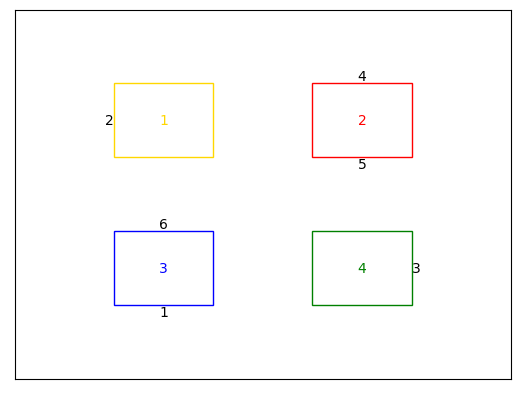

In [6]:
# Plot layout of maze
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.figure('Maze Layout')
ax = plt.gca()
ax.set_xlim([0, 40])
ax.set_ylim([0, 40])
ax.set_xticks([])
ax.set_yticks([])
# Add maze pillars
ax.add_patch(Rectangle((8, 8), 8, 8, edgecolor='blue', fill=False, linewidth=1))
ax.add_patch(Rectangle((8, 24), 8, 8, edgecolor='gold', fill=False, linewidth=1))
ax.add_patch(Rectangle((24, 8), 8, 8, edgecolor='green', fill=False, linewidth=1))
ax.add_patch(Rectangle((24, 24), 8, 8, edgecolor='red', fill=False, linewidth=1))
# Add poster locations
ax.text(12, 8, '1', ha='center', va='top', color='k')
ax.text(8, 28, '2', ha='right', va='center', color='k')
ax.text(32, 12, '3', ha='left', va='center', color='k')
ax.text(28, 32, '4', ha='center', va='bottom', color='k')
ax.text(28, 24, '5', ha='center', va='top', color='k')
ax.text(12, 16, '6', ha='center', va='bottom', color='k')
# Add pillar labels
ax.text(12, 28, '1', ha='center', va='center', color='gold')
ax.text(28, 28, '2', ha='center', va='center', color='red')
ax.text(12, 12, '3', ha='center', va='center', color='blue')
ax.text(28, 12, '4', ha='center', va='center', color='green')

In [7]:
def group_by_goal(timeseries: np.array, goals: np.array) -> list:
    num_goals = 6
    grouped = [np.empty((0, timeseries.shape[1])) for _ in range(num_goals)]
    for idx, goal in enumerate(goals):
        goal = int(goal - 1)
        grouped[goal] = np.vstack((grouped[goal], timeseries[idx,:]))
    return grouped

def euclidean_distance(arr1: np.array, arr2: np.array) -> float:
    return np.linalg.norm(arr1 - arr2)

def pairwise_distances_between(clust1: np.array, clust2: np.array) -> np.array:
    res = list()
    for obs1 in clust1:
        for obs2 in clust2:
            res.append(euclidean_distance(obs1, obs2))
    return np.array(res)

def pairwise_distances_within(clust: np.array) -> np.array:
    res = list()
    for i in range(clust.shape[0] - 1):
        for j in range(i+1, clust.shape[0]):
            obs1, obs2 = clust[i,:], clust[j,:]
            res.append(euclidean_distance(obs1, obs2))
    return np.array(res)

In [8]:
# Slot spikes into cue phase intervals for each trial
spikecounts_per_trial = spike_counts_per_observation(cue_intervals, spike_times)

# Group cue phase spikes according to goal
responses_per_goal = group_by_goal(spikecounts_per_trial, trial_markers)

# Number of responses per goal
num_responses_per_goal = list(map(lambda arr: arr.shape[0], responses_per_goal))

# Some important constants
num_goals = 6
num_pillars = 4
num_cells = len(cell_labels)

In [9]:
# Create 2D list to store results of all pairwise distances between goals
pairwise_distances_goal = [[np.array([]) for _ in range(num_goals)] for _ in range(num_goals)]
mean_distances_goal = np.empty((num_goals, num_goals))
for i in range(num_goals):
    for j in range(i, num_goals):
        group1, group2 = responses_per_goal[i], responses_per_goal[j]
        if i == j:
            distances = pairwise_distances_within(group1)
            pairwise_distances_goal[i][i] = distances
            mean_distances_goal[i,i] = np.mean(distances)
        else:
            distances = pairwise_distances_between(group1, group2)
            pairwise_distances_goal[i][j] = distances
            pairwise_distances_goal[j][i] = pairwise_distances_goal[i][j]
            mean_distances_goal[i,j] = np.mean(distances)
            mean_distances_goal[j,i] = mean_distances_goal[i,j]

# Pool distributions from goals on the same pillar together - 1 and 6, 4 and 5
# Pillar 1: Goal 2, Pillar 2: Goals 4 & 5, Pillar 3: Goals 1 & 6, Pillar 4: Goal 3
pairwise_distances_pillar = [[np.array([]) for _ in range(num_pillars)] for _ in range(num_pillars)]
mean_distances_pillar = np.empty((num_pillars, num_pillars))
goal_to_pillar = {1:3, 2:1, 3:4, 4:2, 5:2, 6:3}
for i in range(num_goals):
    for j in range(i, num_goals):
            i2, j2 = goal_to_pillar[i+1]-1, goal_to_pillar[j+1]-1
            pairwise_distances_pillar[i2][j2] = np.concatenate((pairwise_distances_pillar[i2][j2], pairwise_distances_goal[i][j]))
            if i != j:
                pairwise_distances_pillar[j2][i2] = pairwise_distances_pillar[i2][j2]

for i in range(num_pillars):
    for j in range(i, num_pillars):
        mean_distances_pillar[i,j] = np.mean(pairwise_distances_pillar[i][j])
        if i != j:
            mean_distances_pillar[j,i] = mean_distances_pillar[i,j]

PCA Dimensionality Reduction

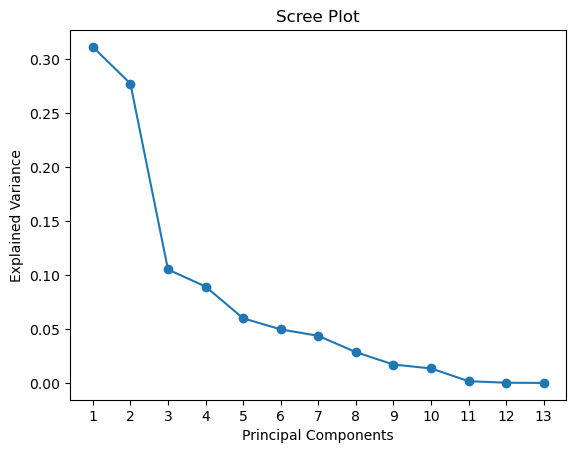

In [10]:
# Perform PCA on the dataset
from sklearn.decomposition import PCA

pca = PCA()
pcs_per_trial = pca.fit_transform(spikecounts_per_trial)

plt.figure()
plt.title('Scree Plot')
plt.plot(np.arange(pca.n_components_), pca.explained_variance_ratio_, 'o-')
plt.xticks(np.arange(pca.n_components_), labels=np.arange(1, pca.n_components_+1))
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.show()

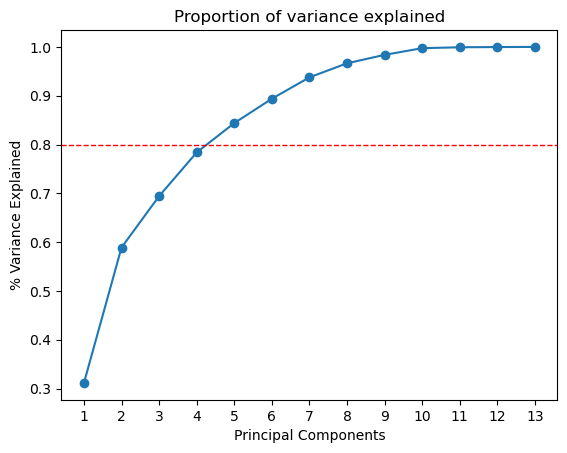

In [11]:
cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.title('Proportion of variance explained')
plt.plot(np.arange(pca.n_components_), cumulative_variance_explained, 'o-')
plt.axhline(y=0.8, color='r', linestyle='--', linewidth=1)
plt.xticks(np.arange(pca.n_components_), labels=np.arange(1, pca.n_components_+1))
plt.xlabel('Principal Components')
plt.ylabel('% Variance Explained')
plt.show()

In [12]:
pca = PCA(0.8)
pcs_per_trial = pca.fit_transform(spikecounts_per_trial)
responses_per_goal_pca = group_by_goal(pcs_per_trial, trial_markers)

# Create 2D list to store results of all pairwise distances between goals
pairwise_distances_goal_pca = [[np.array([]) for _ in range(num_goals)] for _ in range(num_goals)]
mean_distances_goal_pca = np.empty((num_goals, num_goals))
for i in range(num_goals):
    for j in range(i, num_goals):
        group1, group2 = responses_per_goal_pca[i], responses_per_goal_pca[j]
        if i == j:
            distances = pairwise_distances_within(group1)
            pairwise_distances_goal_pca[i][i] = distances
            mean_distances_goal_pca[i,i] = np.mean(distances)
        else:
            distances = pairwise_distances_between(group1, group2)
            pairwise_distances_goal_pca[i][j] = distances
            pairwise_distances_goal_pca[j][i] = pairwise_distances_goal_pca[i][j]
            mean_distances_goal_pca[i,j] = np.mean(distances)
            mean_distances_goal_pca[j,i] = mean_distances_goal_pca[i,j]

# Pool distributions from goals on the same pillar together - 1 and 6, 4 and 5
# Pillar 1: Goal 2, Pillar 2: Goals 4 & 5, Pillar 3: Goals 1 & 6, Pillar 4: Goal 3
pairwise_distances_pillar_pca = [[np.array([]) for _ in range(num_pillars)] for _ in range(num_pillars)]
mean_distances_pillar_pca = np.empty((num_pillars, num_pillars))
goal_to_pillar = {1:3, 2:1, 3:4, 4:2, 5:2, 6:3}
for i in range(num_goals):
    for j in range(i, num_goals):
            i2, j2 = goal_to_pillar[i+1]-1, goal_to_pillar[j+1]-1
            pairwise_distances_pillar_pca[i2][j2] = np.concatenate((pairwise_distances_pillar_pca[i2][j2], pairwise_distances_goal_pca[i][j]))
            if i != j:
                pairwise_distances_pillar_pca[j2][i2] = pairwise_distances_pillar_pca[i2][j2]

for i in range(num_pillars):
    for j in range(i, num_pillars):
        mean_distances_pillar_pca[i,j] = np.mean(pairwise_distances_pillar_pca[i][j])
        if i != j:
            mean_distances_pillar_pca[j,i] = mean_distances_pillar_pca[i,j]

num_pcs = pcs_per_trial.shape[1]
print(f'Number of principal components used: {num_pcs}')

Number of principal components used: 5


LDA Transformation

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(spikecounts_per_trial, trial_markers)
lda_space_per_trial = lda.transform(spikecounts_per_trial)
responses_per_goal_lda = group_by_goal(lda_space_per_trial, trial_markers)

# Create 2D list to store results of all pairwise distances between goals
pairwise_distances_goal_lda = [[np.array([]) for _ in range(num_goals)] for _ in range(num_goals)]
mean_distances_goal_lda = np.empty((num_goals, num_goals))
for i in range(num_goals):
    for j in range(i, num_goals):
        group1, group2 = responses_per_goal_lda[i], responses_per_goal_lda[j]
        if i == j:
            distances = pairwise_distances_within(group1)
            pairwise_distances_goal_lda[i][i] = distances
            mean_distances_goal_lda[i,i] = np.mean(distances)
        else:
            distances = pairwise_distances_between(group1, group2)
            pairwise_distances_goal_lda[i][j] = distances
            pairwise_distances_goal_lda[j][i] = pairwise_distances_goal_lda[i][j]
            mean_distances_goal_lda[i,j] = np.mean(distances)
            mean_distances_goal_lda[j,i] = mean_distances_goal_lda[i,j]

# Pool distributions from goals on the same pillar together - 1 and 6, 4 and 5
# Pillar 1: Goal 2, Pillar 2: Goals 4 & 5, Pillar 3: Goals 1 & 6, Pillar 4: Goal 3
pairwise_distances_pillar_lda = [[np.array([]) for _ in range(num_pillars)] for _ in range(num_pillars)]
mean_distances_pillar_lda = np.empty((num_pillars, num_pillars))
goal_to_pillar = {1:3, 2:1, 3:4, 4:2, 5:2, 6:3}
for i in range(num_goals):
    for j in range(i, num_goals):
            i2, j2 = goal_to_pillar[i+1]-1, goal_to_pillar[j+1]-1
            pairwise_distances_pillar_lda[i2][j2] = np.concatenate((pairwise_distances_pillar_lda[i2][j2], pairwise_distances_goal_lda[i][j]))
            if i != j:
                pairwise_distances_pillar_lda[j2][i2] = pairwise_distances_pillar_lda[i2][j2]

for i in range(num_pillars):
    for j in range(i, num_pillars):
        mean_distances_pillar_lda[i,j] = np.mean(pairwise_distances_pillar_lda[i][j])
        if i != j:
            mean_distances_pillar_lda[j,i] = mean_distances_pillar_lda[i,j]

Plots

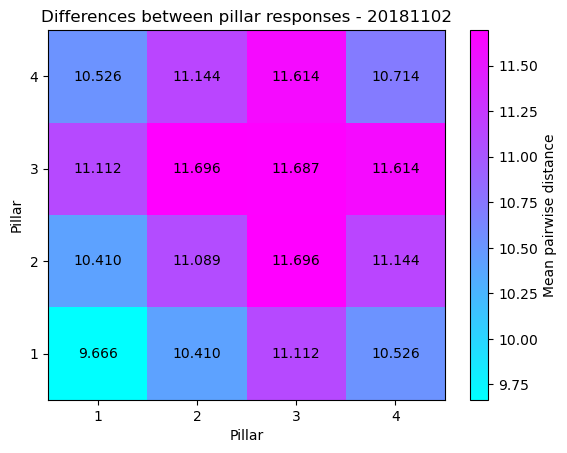

In [14]:
# Plot heatmap of mean distances
plt.figure()
ax = plt.gca()
plt.title(f'Differences between pillar responses - {day_dir}')
plt.pcolormesh(mean_distances_pillar, cmap='cool')
plt.colorbar(label='Mean pairwise distance')
plt.xticks(np.arange(0.5, num_pillars+0.5), labels=np.arange(1, num_pillars+1))
plt.yticks(np.arange(0.5, num_pillars+0.5), labels=np.arange(1, num_pillars+1))
plt.xlabel('Pillar')
plt.ylabel('Pillar')
for i, row in enumerate(mean_distances_pillar):
    for j, val in enumerate(row):
        ax.text(j+0.5, i+0.5, f'{val:.3f}', ha='center', va='center', color='k')
plt.show()

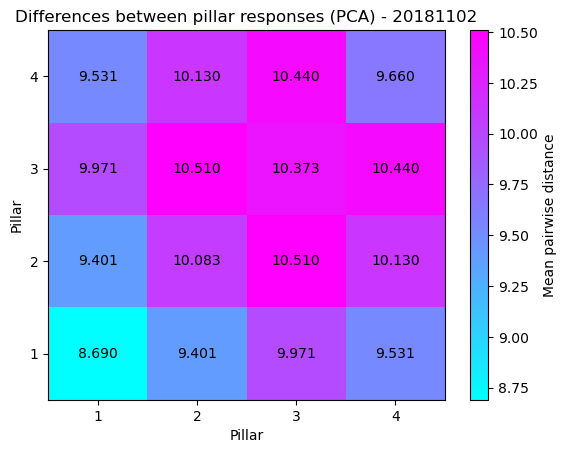

In [15]:
# Plot heatmap of mean distances (PCA)
plt.figure()
ax = plt.gca()
plt.title(f'Differences between pillar responses (PCA) - {day_dir}')
plt.pcolormesh(mean_distances_pillar_pca, cmap='cool')
plt.colorbar(label='Mean pairwise distance')
plt.xticks(np.arange(0.5, num_pillars+0.5), labels=np.arange(1, num_pillars+1))
plt.yticks(np.arange(0.5, num_pillars+0.5), labels=np.arange(1, num_pillars+1))
plt.xlabel('Pillar')
plt.ylabel('Pillar')
for i, row in enumerate(mean_distances_pillar_pca):
    for j, val in enumerate(row):
        ax.text(j+0.5, i+0.5, f'{val:.3f}', ha='center', va='center', color='k')
plt.show()

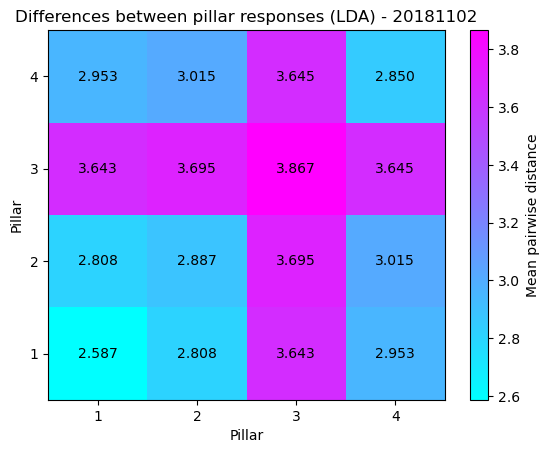

In [16]:
# Plot heatmap of mean distances (LDA)
plt.figure()
ax = plt.gca()
plt.title(f'Differences between pillar responses (LDA) - {day_dir}')
plt.pcolormesh(mean_distances_pillar_lda, cmap='cool')
plt.colorbar(label='Mean pairwise distance')
plt.xticks(np.arange(0.5, num_pillars+0.5), labels=np.arange(1, num_pillars+1))
plt.yticks(np.arange(0.5, num_pillars+0.5), labels=np.arange(1, num_pillars+1))
plt.xlabel('Pillar')
plt.ylabel('Pillar')
for i, row in enumerate(mean_distances_pillar_lda):
    for j, val in enumerate(row):
        ax.text(j+0.5, i+0.5, f'{val:.3f}', ha='center', va='center', color='k')
plt.show()

In [17]:
# Choose goal to plot boxplot distributions
pillar_num = 0  # 0-indexed

In [18]:
# Peform Wilcoxon rank-sum tests to check for significant differences between distance distributions of each goal
from scipy import stats

test_stats, p_vals = list(), list()
test_stats_pca, p_vals_pca = list(), list()
test_stats_lda, p_vals_lda = list(), list()

for pillar in range(num_pillars):

    if pillar == pillar_num:
        test_stats.append('-')
        test_stats_pca.append('-')
        test_stats_lda.append('-')
        p_vals.append('-')
        p_vals_pca.append('-')
        p_vals_lda.append('-')
        continue

    test_stat, p_val = stats.ranksums(pairwise_distances_pillar[pillar_num][pillar], pairwise_distances_pillar[pillar_num][pillar_num])
    test_stat_pca, p_val_pca = stats.ranksums(pairwise_distances_pillar_pca[pillar_num][pillar], pairwise_distances_pillar_pca[pillar_num][pillar_num])
    test_stat_lda, p_val_lda = stats.ranksums(pairwise_distances_pillar_lda[pillar_num][pillar], pairwise_distances_pillar_lda[pillar_num][pillar_num])

    test_stats.append(f'{test_stat:.3e}')
    test_stats_pca.append(f'{test_stat_pca:.3e}')
    test_stats_lda.append(f'{test_stat_lda:.3e}')
    p_vals.append(f'{p_val:.3e}')
    p_vals_pca.append(f'{p_val_pca:.3e}')
    p_vals_lda.append(f'{p_val_lda:.3e}')


# Compute effect sizes of differences between distance distributions of each goal
def cohen_d(sample1: np.array, sample2: np.array) -> float:
    x1, x2 = np.mean(sample1), np.mean(sample2)
    s1, s2 = np.std(sample1, ddof=1), np.std(sample2, ddof=1)
    n1, n2 = sample1.shape[0], sample2.shape[0]
    s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    return (x1 - x2) / s_pooled

fx_sizes, fx_sizes_pca, fx_sizes_lda = list(), list(), list()
for pillar in range(num_pillars):
    if pillar == pillar_num:
        fx_sizes.append('-')
        fx_sizes_pca.append('-')
        fx_sizes_lda.append('-')
        continue

    fx_size = cohen_d(pairwise_distances_pillar[pillar_num][pillar], pairwise_distances_pillar[pillar_num][pillar_num])
    fx_size_pca = cohen_d(pairwise_distances_pillar_pca[pillar_num][pillar], pairwise_distances_pillar_pca[pillar_num][pillar_num])
    fx_size_lda = cohen_d(pairwise_distances_pillar_lda[pillar_num][pillar], pairwise_distances_pillar_lda[pillar_num][pillar_num])

    fx_sizes.append(f'{fx_size:.3f}')
    fx_sizes_pca.append(f'{fx_size_pca:.3f}')
    fx_sizes_lda.append(f'{fx_size_lda:.3f}')

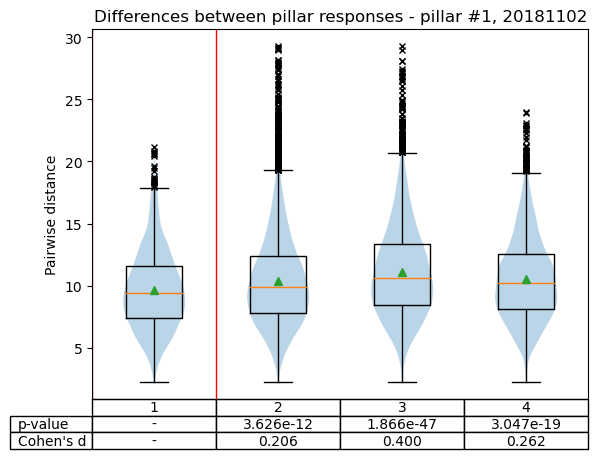

In [19]:
# Plot boxplot distribution of distances between one goal and the rest
plt.figure()
plt.title(f'Differences between pillar responses - pillar #{pillar_num+1}, {day_dir}')
plt.boxplot(pairwise_distances_pillar[pillar_num], showmeans=True, flierprops={'marker': 'x', 'markersize': 4})
plt.violinplot(pairwise_distances_pillar[pillar_num], showextrema=False)
plt.axvline(x=pillar_num+0.5, color='r', linewidth=1)
plt.axvline(x=pillar_num+1.5, color='r', linewidth=1)
plt.table(cellText=[p_vals, fx_sizes], rowLabels=['p-value', 'Cohen\'s d'], colLabels=list(range(1, num_goals+1)), cellLoc='center')
plt.xticks([])
# plt.xlabel('Pillar')
plt.ylabel('Pairwise distance')
plt.show()

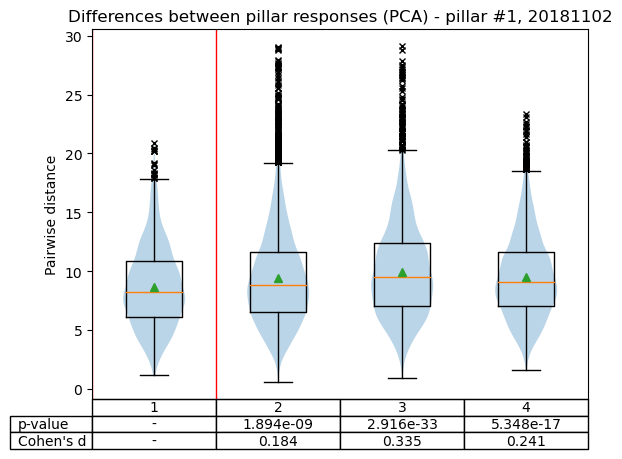

In [20]:
# Plot boxplot distribution of distances between one goal and the rest (PCA)
plt.figure()
plt.title(f'Differences between pillar responses (PCA) - pillar #{pillar_num+1}, {day_dir}')
plt.boxplot(pairwise_distances_pillar_pca[pillar_num], showmeans=True, flierprops={'marker': 'x', 'markersize': 4})
plt.violinplot(pairwise_distances_pillar_pca[pillar_num], showextrema=False)
plt.axvline(x=pillar_num+0.5, color='r', linewidth=1)
plt.axvline(x=pillar_num+1.5, color='r', linewidth=1)
plt.table(cellText=[p_vals_pca, fx_sizes_pca], rowLabels=['p-value', 'Cohen\'s d'], colLabels=list(range(1, num_goals+1)), cellLoc='center')
plt.xticks([])
# plt.xlabel('Pillar')
plt.ylabel('Pairwise distance')
plt.show()

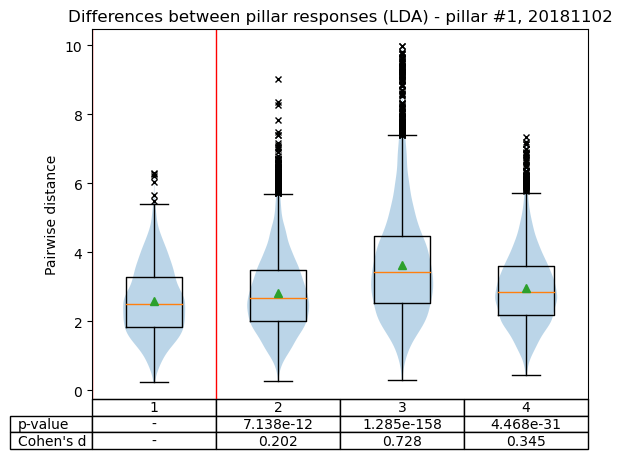

In [21]:
# Plot boxplot distribution of distances between one goal and the rest (LDA)
plt.figure()
plt.title(f'Differences between pillar responses (LDA) - pillar #{pillar_num+1}, {day_dir}')
plt.boxplot(pairwise_distances_pillar_lda[pillar_num], showmeans=True, flierprops={'marker': 'x', 'markersize': 4})
plt.violinplot(pairwise_distances_pillar_lda[pillar_num], showextrema=False)
plt.axvline(x=pillar_num+0.5, color='r', linewidth=1)
plt.axvline(x=pillar_num+1.5, color='r', linewidth=1)
plt.table(cellText=[p_vals_lda, fx_sizes_lda], rowLabels=['p-value', 'Cohen\'s d'], colLabels=list(range(1, num_goals+1)), cellLoc='center')
plt.xticks([])
# plt.xlabel('Pillar')
plt.ylabel('Pairwise distance')
plt.show()

In [22]:
# Pillar 2 goals vs all other goals, Euclidean space
goal1, goal2 = 4, 5  # 1-indexed
pillar_2_dists = [pairwise_distances_goal[goal1-1][goal2-1]]
pillar_2_labels = [(goal1, goal2)]

for goal in range(1, num_goals+1):
    if goal == goal1 or goal == goal2:
        continue
    pillar_2_dists.append(pairwise_distances_goal[goal1-1][goal-1])
    pillar_2_labels.append((goal1, goal))
for goal in range(1, num_goals+1):
    if goal == goal1 or goal == goal2:
        continue
    pillar_2_dists.append(pairwise_distances_goal[goal2-1][goal-1])
    pillar_2_labels.append((goal2, goal))

pillar_2_pvals, pillar_2_fxs = ['-'], ['-']
for dist in pillar_2_dists[1:]:
    test_stat, p_val = stats.ranksums(dist, pillar_2_dists[0])
    fx_size = cohen_d(dist, pillar_2_dists[0])
    pillar_2_pvals.append(f'{p_val:.3e}')
    pillar_2_fxs.append(f'{fx_size:.3f}')

# Pillar 3 goals vs all other goals, Euclidean space
goal1, goal2 = 1, 6  # 1-indexed
pillar_3_dists = [pairwise_distances_goal[goal1-1][goal2-1]]
pillar_3_labels = [(goal1, goal2)]

for goal in range(1, num_goals+1):
    if goal == goal1 or goal == goal2:
        continue
    pillar_3_dists.append(pairwise_distances_goal[goal1-1][goal-1])
    pillar_3_labels.append((goal1, goal))
for goal in range(1, num_goals+1):
    if goal == goal1 or goal == goal2:
        continue
    pillar_3_dists.append(pairwise_distances_goal[goal2-1][goal-1])
    pillar_3_labels.append((goal2, goal))

pillar_3_pvals, pillar_3_fxs = ['-'], ['-']
for dist in pillar_3_dists[1:]:
    test_stat, p_val = stats.ranksums(dist, pillar_3_dists[0])
    fx_size = cohen_d(dist, pillar_3_dists[0])
    pillar_3_pvals.append(f'{p_val:.3e}')
    pillar_3_fxs.append(f'{fx_size:.3f}')

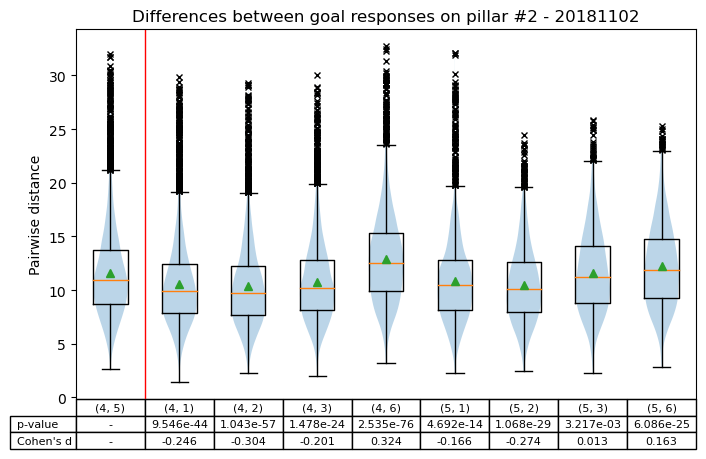

In [23]:
# Plot pairwise distance distributions between pillar 2 goals and the rest
plt.figure(figsize=(8, 4.8))
plt.title(f'Differences between goal responses on pillar #2 - {day_dir}')
plt.boxplot(pillar_2_dists, showmeans=True, flierprops={'marker': 'x', 'markersize': 4})
plt.violinplot(pillar_2_dists, showextrema=False)
plt.axvline(x=1.5, color='r', linewidth=1)
plt.table(cellText=[pillar_2_pvals, pillar_2_fxs], rowLabels=['p-value', 'Cohen\'s d'], colLabels=pillar_2_labels, cellLoc='center')
plt.xticks([])
# plt.xlabel('Pillar')
plt.ylabel('Pairwise distance')
plt.show()

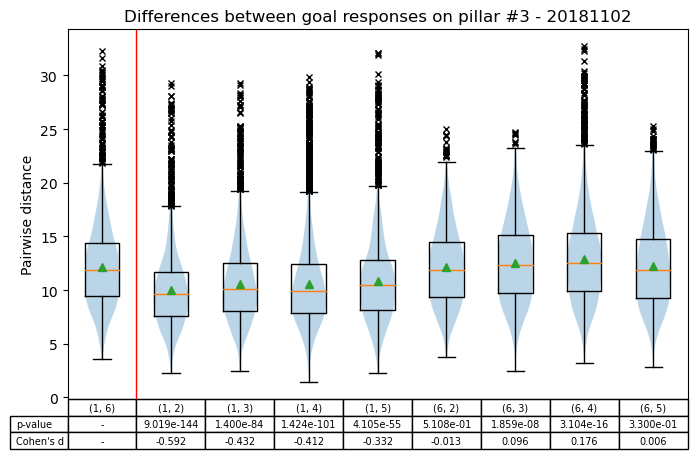

In [24]:
# Plot pairwise distance distributions between pillar 3 goals and the rest
plt.figure(figsize=(8, 4.8))
plt.title(f'Differences between goal responses on pillar #3 - {day_dir}')
plt.boxplot(pillar_3_dists, showmeans=True, flierprops={'marker': 'x', 'markersize': 4})
plt.violinplot(pillar_3_dists, showextrema=False)
plt.axvline(x=1.5, color='r', linewidth=1)
plt.table(cellText=[pillar_3_pvals, pillar_3_fxs], rowLabels=['p-value', 'Cohen\'s d'], colLabels=pillar_3_labels, cellLoc='center')
plt.xticks([])
# plt.xlabel('Pillar')
plt.ylabel('Pairwise distance')
plt.show()